# Wavenet Hyperparameter Tuning

In [ ]:
# !pip install ray[tune]

In [ ]:
# !pip install optuna

In [ ]:
import numpy as np
import torch

import random
import os
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import ray
from ray import tune
from ray.tune import CLIReporter, JupyterNotebookReporter
from ray.tune.schedulers import ASHAScheduler
from ray.tune.schedulers.pb2 import PB2
from ray.air import session
from ray.tune.suggest.optuna import OptunaSearch
from ray.air import Result

In [ ]:
device = "cpu"
if torch.cuda.is_available():
    device = "cuda:0"

In [ ]:
device

'cuda:0'

In [ ]:
torch.manual_seed(42);

In [ ]:
random.seed(42)

### Setup Data Loader

In [ ]:
words = open('names.txt', 'r').read().splitlines()

In [ ]:
random.shuffle(words)

In [ ]:
def build_dataset(words, block_size=8):
    
    X, Y = [], []
    
    random.seed(42)
    random.shuffle(words)
    
    chars = sorted(list(set(''.join(words))))
    stoi = {s: i + 1 for i, s in enumerate(chars)}
    stoi['.'] = 0
    itos = {i: s for s, i in stoi.items()}
    vocab_size = len(itos)
    
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    
    X = torch.tensor(X).to(device)
    Y = torch.tensor(Y).to(device)
    return X, Y

n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

In [ ]:
Xtr.shape

torch.Size([182625, 8])

### Create Model 

In [ ]:
# --- Tanh --- layer
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x).to(device)
        return self.out
    
    def parameters(self):
        return []
    
# --- Linear --- layer
class Linear:
    
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = (torch.randn((fan_in, fan_out)) / fan_in ** 0.5).to(device) # note: kaiming init
        self.bias = torch.zeros(fan_out).to(device) if bias else None #
    
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])


# --- Embedding --- layer
class Embedding: 
    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn((num_embeddings, embedding_dim)).to(device)
        
    def __call__(self, IX):
        self.out = self.weight[IX]
        return self.out
    
    def parameters(self):
        return [self.weight]

# --- Sequential ----
class Sequential:
    def __init__(self, layers):
        self.layers = layers
        
    def __call__(self, x):
        B, T, C = x.shape
        x = x.view(B, T//self.n, C*self.n)
        if x.shape[1] == 1: 
            x = x.squeeze(1)
        self.out = x
        return self.out
    
    def parameters(self):
        # get parameters of all layers and stretch them out into one list
        return [p for layer in self.layers for p in layer.parameters()]

# --- BatchNorm1d ---
class BatchNorm1d:
    
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim).to(device)
        self.beta = torch.zeros(dim).to(device)
        # buffers (trained with a running `momentum update`)
        self.running_mean = torch.zeros(dim).to(device)
        self.running_var = torch.ones(dim).to(device)
    
    def __call__(self, x):
        # calculate the forward pass
        if self.training:
            if x.ndim == 2: dim = 0
            elif x.ndim == 3: dim = (0, 1)
            xmean = x.mean(dim, keepdim=True)
            xvar = x.var(dim, keepdim=True)
        else:
            # print('In batchnorm call')
            xmean = self.running_mean
            xvar = self.running_var
        
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta
        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]

# --- Flatten Consecutive ---
class FlattenConsecutive:
    def __init__(self, n):
        self.n = n
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out
    
    def parameters(self):
        # get parameters of all layers and stretch them out into one list
        return [p for layer in self.layers for p in layer.parameters()]

In [ ]:
def build_model(n_embd, # the dimensionality of the character embedding vectors
                n_hidden, # the number of neurons in the hidden layer of the MLP 
                last_layer_factor = 0.1 # the factor by to reduce the weights of the last layer
               ):
    vocab_size = 27
    model = Sequential([
        Embedding(vocab_size, n_embd),
        FlattenConsecutive(2), Linear(n_embd*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
        FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
        FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
        Linear(n_hidden, vocab_size),
    ])


    # parameter init
    with torch.no_grad(): model.layers[-1].weight *= last_layer_factor

    parameters = model.parameters()
    print("No of parameters ", sum(p.nelement() for p in parameters))
    for p in parameters: p.requires_grad = True
    return model

76579


In [ ]:
model = build_model(24, 128)

In [ ]:
ix = torch.randint(0, Xtr.shape[0], (4,))
Xb, Yb = Xtr[ix], Ytr[ix]
logits = model(Xb)
print(Xb.shape)
Xb

torch.Size([4, 8])


tensor([[ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  6],
        [ 0,  0,  0,  0,  0,  0,  0, 12],
        [ 0,  0,  0,  2, 18,  9,  5, 12]])

In [ ]:
logits

tensor([[ 0.0273, -0.0539,  0.0103,  0.0468,  0.0906, -0.0791,  0.0134, -0.0599,
         -0.0407, -0.0617,  0.0134, -0.0230, -0.0095,  0.0769,  0.0231,  0.0755,
         -0.0331, -0.0292,  0.0256, -0.1219,  0.0147, -0.0233,  0.0642, -0.0846,
         -0.1325,  0.0057,  0.1157],
        [ 0.0004,  0.0353, -0.0831,  0.0284, -0.0333,  0.0517, -0.0613, -0.0264,
          0.0924, -0.0422, -0.0844, -0.0041,  0.0009,  0.0050,  0.0096,  0.0046,
          0.0754, -0.0220, -0.0776,  0.0863, -0.0258,  0.0097,  0.1024,  0.0146,
          0.1084, -0.0321, -0.0900],
        [-0.0469,  0.0274,  0.0240,  0.0247, -0.0269, -0.0069,  0.1197, -0.0066,
         -0.1216,  0.0030, -0.0689, -0.0530,  0.0465, -0.0710, -0.0207, -0.0524,
         -0.0485,  0.0697,  0.0468,  0.0067, -0.0114,  0.0317, -0.0701,  0.0484,
          0.1649,  0.0206, -0.0751],
        [ 0.0238, -0.0383, -0.0129, -0.1187, -0.0069, -0.0030, -0.0763,  0.0728,
          0.0896,  0.1063,  0.1267,  0.0320, -0.0092, -0.0483, -0.0477, -0.0461

In [ ]:
for i, ix in enumerate(batch(range(10))):
    print(i, ix)

0 range(0, 1)
1 range(1, 2)
2 range(2, 3)
3 range(3, 4)
4 range(4, 5)
5 range(5, 6)
6 range(6, 7)
7 range(7, 8)
8 range(8, 9)
9 range(9, 10)


In [ ]:
def batch(iterable, n=1):
    l = len(iterable)
    for ndx in range(0, l, n):
        yield iterable[ndx:min(ndx + n, l)]

In [ ]:
for i, ix in enumerate(batch(range(10))):
    print(i, ix)

0 range(0, 1)
1 range(1, 2)
2 range(2, 3)
3 range(3, 4)
4 range(4, 5)
5 range(5, 6)
6 range(6, 7)
7 range(7, 8)
8 range(8, 9)
9 range(9, 10)


In [ ]:
# same optimization as last time
def train_no_tune(config, checkpoint_dir=None):
    
    n_embd = config['n_embd']
    n_hidden = config['n_hidden']
    last_layer_factor = config['last_layer_factor']
    max_steps = config['max_steps'] 
    lr = config['lr']
    batch_size = config['batch_size']
    
    model = build_model(n_embd, n_hidden, last_layer_factor)

    train_loss = F.cross_entropy(model(Xtr), Ytr)
    print('Initial loss ', train_loss)
    
    lossi = []
    
    for i in range(max_steps):
        running_loss = 0.0
        epoch_steps = 0
        # minibatch construct
        ix = torch.randint(0, Xtr.shape[0], (batch_size,))
        Xb, Yb = Xtr[ix], Ytr[ix]


        # forward pass
        logits = model(Xb)
        loss = F.cross_entropy(logits, Yb)

        # backward pass
        for p in model.parameters():
            p.grad = None
        loss.backward()

        # update: simple SGD
        # lr = 0.1 if i < 150_000 else 0.01 # step learning rate decay
        for p in model.parameters(): 
            p.data += -lr * p.grad

        # track stats
        if i % 10_000 == 0:
            print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
        lossi.append(loss.log10().item())
    
#     print(model)
        
    return model
                
#     print(train_loss.item(), val_loss.item())

In [ ]:
config = {
        "n_embd": 24,
        "n_hidden": 128,
        "lr": 0.1,
        "last_layer_factor": 0.1,
        "batch_size": 32,
        "max_steps": 150_000
    }

In [ ]:
m = train_no_tune(config)

In [ ]:
ix = torch.randint(0, Xtr.shape[0], (4,))
Xb, Yb = Xtr[ix], Ytr[ix]
logits = m(Xb)
logits

tensor([[ 7.3465,  3.0281, -0.8438, -0.6315,  0.1254,  2.3173, -5.4998, -3.1930,
          1.5278,  1.3920, -0.8801,  0.2029,  0.6476,  1.1801,  3.3868, -0.4111,
         -3.7620, -2.9908,  2.5343,  2.5573, -1.7074,  1.2317, -2.6614, -0.9130,
         -1.6869, -1.5149, -0.9145],
        [ 1.1573,  6.1267, -1.6542, -0.7126, -0.0082,  7.1435, -3.1067, -2.7086,
         -0.5152,  5.9013, -1.5665, -2.7343, -0.8459, -2.8573,  0.9811,  5.7301,
         -2.6570, -4.4699,  2.2010, -1.5982, -1.9610,  2.9759,  0.5002, -2.5367,
         -3.4369,  5.2291, -4.5067],
        [ 7.1585,  2.8464,  0.2289, -0.9455,  1.5724,  0.8947, -1.6819,  8.0458,
         -3.1600, -1.8369, -0.4268,  0.1184, -0.3447, -0.5721,  2.6477,  0.2432,
         -2.7675, -2.0082,  1.5645,  1.6701, -0.3294, -2.4148, -3.6991, -3.9939,
         -2.7473,  0.7778, -1.0990],
        [-0.6448,  5.7704, -0.8307,  0.5714, -1.6713,  5.6905, -2.8324, -4.6171,
          1.4003,  7.0470, -1.9388, -1.7307, -1.1796, -0.9947, -1.5239,  2.1725

In [ ]:
for layer in m.layers: layer.training = False
train_loss = F.cross_entropy(m(Xtr), Ytr).item() 
val_loss = F.cross_entropy(m(Xdev), Ydev).item()
train_loss, val_loss

(1.858979344367981, 2.039809226989746)

### Tuning

In [ ]:
def train(config):
    
    n_embd = config['n_embd']
    n_hidden = config['n_hidden']
    last_layer_factor = config['last_layer_factor']
    max_steps = config['max_steps'] 
    lr = config['lr']
    batch_size = config['batch_size']
    
    model = build_model(n_embd, n_hidden, last_layer_factor)

    train_loss = F.cross_entropy(model(Xtr), Ytr)
    print('Initial loss ', train_loss)
    
    lossi = []
    
    # max_steps = 100_00_000
    
    for i in range(max_steps):
        running_loss = 0.0
        epoch_steps = 0
        # minibatch construct
        ix = torch.randint(0, Xtr.shape[0], (batch_size,))
        Xb, Yb = Xtr[ix], Ytr[ix]


        # forward pass
        logits = model(Xb)
        loss = F.cross_entropy(logits, Yb)

        # backward pass
        for p in model.parameters():
            p.grad = None
        loss.backward()

        # update: simple SGD
        for p in model.parameters(): 
            p.data += -lr * p.grad

        # track stats
        # if i % 10_000 == 0: # print every once in a while
        #     # print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
            
        for layer in model.layers: layer.training = False
        train_loss = F.cross_entropy(model(Xtr), Ytr) 
        val_loss = F.cross_entropy(model(Xdev), Ydev)
        session.report({'training_iteration':i, 'train_loss':train_loss.item(), 'val_loss':val_loss.item()})
        for layer in model.layers: layer.training = True
            
        lossi.append(loss.log10().item())
    
    print('Train Loss ', F.cross_entropy(model(Xtr), Ytr).item())
    print('Val Loss ', F.cross_entropy(model(Xdev), Ydev).item())

      0/ 300000: 3.2818
  10000/ 300000: 2.3348
  20000/ 300000: 2.0034
  30000/ 300000: 1.9822
  40000/ 300000: 1.5388
  50000/ 300000: 1.9057
  60000/ 300000: 1.6040
  70000/ 300000: 2.0101
  80000/ 300000: 2.2422
  90000/ 300000: 1.6573
 100000/ 300000: 1.7261
 110000/ 300000: 1.8587
 120000/ 300000: 1.5202
 130000/ 300000: 2.0675
 140000/ 300000: 1.9777
 150000/ 300000: 2.0351
 160000/ 300000: 1.6458
 170000/ 300000: 1.8868
 180000/ 300000: 1.7516
 190000/ 300000: 1.6009
 200000/ 300000: 1.3999
 210000/ 300000: 1.7495
 220000/ 300000: 1.6129
 230000/ 300000: 1.7232
 240000/ 300000: 2.2450
 250000/ 300000: 2.2155
 260000/ 300000: 1.5074
 270000/ 300000: 1.6431
 280000/ 300000: 1.7525
 290000/ 300000: 1.8047


In [ ]:
def tuning():
    search_space = {
        "n_embd": tune.randint(4, 65),
        "n_hidden": tune.randint(100, 500),
        "lr": tune.loguniform(1e-4, 1e-1),
        "last_layer_factor": tune.uniform(0.1, 1.01),
        "batch_size": tune.choice([16, 32, 64]),
        "max_steps": tune.randint(100_000, 10_00_000)
    }
    
    initial_params = [{
        "n_embd": 24, 
        "n_hidden": 128,
        "lr": 0.1,
        "last_layer_factor": 0.1,
        "batch_size": 32,
        "max_steps": 150_000
    }]
    
    searcher = OptunaSearch(points_to_evaluate=initial_params)
    trainable_with_cpu_gpu = tune.with_resources(train, {"cpu": 30, "gpu": 1})
    
    tuner = tune.Tuner(
        trainable_with_cpu_gpu,
        tune_config=tune.TuneConfig(
            metric="val_loss",
            mode="min",
            search_alg=searcher,
            num_samples=7,
        ),
        param_space=search_space,
    )
    
    results = tuner.fit()
    
    print("Best hyperparameters found were: ", results.get_best_result().config)

In [ ]:
ray.shutdown(); 
ray.init()

2023-03-19 17:02:02,578	INFO worker.py:1553 -- Started a local Ray instance.


Python version:,3.8.10
Ray version:,2.3.0


In [ ]:
tuning()

/home/ubuntu/.local/lib/python3.8/site-packages/ray/tune/search/optuna/optuna_search.py:683: FutureWarning: IntUniformDistribution has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :class:`~optuna.distributions.IntDistribution` instead.
  return ot.distributions.IntUniformDistribution(
/home/ubuntu/.local/lib/python3.8/site-packages/ray/tune/search/optuna/optuna_search.py:662: FutureWarning: LogUniformDistribution has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :class:`~optuna.distributions.FloatDistribution` instead.
  return ot.distributions.LogUniformDistribution(
/home/ubuntu/.local/lib/python3.8/site-packages/ray/tune/search/optuna/optuna_search.py:671: FutureWarning: UniformDistribution has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. U

[<matplotlib.lines.Line2D>]

/home/ubuntu/.local/lib/python3.8/site-packages/optuna/distributions.py:799: FutureWarning: IntUniformDistribution(high=64, low=4, step=1) is deprecated and internally converted to IntDistribution(high=64, log=False, low=4, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/home/ubuntu/.local/lib/python3.8/site-packages/optuna/distributions.py:799: FutureWarning: IntUniformDistribution(high=499, low=100, step=1) is deprecated and internally converted to IntDistribution(high=499, log=False, low=100, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/home/ubuntu/.local/lib/python3.8/site-packages/optuna/distributions.py:799: FutureWarning: LogUniformDistribution(high=0.1, low=0.0001) is deprecated and internally converted to FloatDistribution(high=0.1, log=True, low=0.0001, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/home/ubuntu/.loc

(train pid=88428) No of parameters  76579


Trial name,date,done,episodes_total,experiment_id,hostname,iterations_since_restore,node_ip,pid,time_since_restore,time_this_iter_s,time_total_s,timestamp,timesteps_since_restore,timesteps_total,train_loss,training_iteration,trial_id,val_loss,warmup_time
train_e8e76444,2023-03-19_17-50-55,True,,352e72ef24b0485790725bb268154829,129-146-49-170,150000,10.19.31.32,88428,2925.94,0.0204446,2925.94,1679248255,0,,1.88007,149999,e8e76444,2.06663,0.00304294
train_f6250653,2023-03-19_23-14-47,False,,352e72ef24b0485790725bb268154829,129-146-49-170,302648,10.19.31.32,88428,19431.6,0.0662513,19431.6,1679267687,0,,1.85784,302647,f6250653,1.99851,0.00304294


(train pid=88428) Initial loss  tensor(3.2965, device='cuda:0', grad_fn=<NllLossBackward0>)
(train pid=88428) Train Loss  1.873051643371582
(train pid=88428) Val Loss  2.0602710247039795
(train pid=88428) No of parameters  869355
(train pid=88428) Initial loss  
(train pid=88428) tensor(3.4301, device='cuda:0', grad_fn=<NllLossBackward0>)


### Analyze the Ray Tune trials

All the trials' information did not show up above therefore doing the analysis in the folowing cells

In [ ]:
experiment_path = f"ray_results/train_2023-03-19_17-02-06"
print(f"Loading results from {experiment_path}...")

Loading results from ray_results/train_2023-03-19_17-02-06...


In [ ]:
restored_tuner = tune.Tuner.restore(experiment_path)
result_grid = restored_tuner.get_results()

/home/ubuntu/.local/lib/python3.8/site-packages/ray/tune/tuner.py:230: UserWarning: Passing in the experiment's `trainable` will be a required argument to `Tuner.restore` starting from version 2.5. Please specify the trainable to avoid this warning.
  warnings.warn(warning_message)
2023-03-21 14:13:11,149	INFO experiment_analysis.py:789 -- No `self.trials`. Drawing logdirs from checkpoint file. This may result in some information that is out of sync, as checkpointing is periodic.


In [ ]:
results_df = result_grid.get_dataframe()
results_df[["training_iteration", "val_loss"]]

,training_iteration,val_loss
0,870783,2.044881
1,423444,2.018260
2,762047,2.015049
3,149999,2.066634
4,199144,2.051399
5,289118,2.046853
6,540059,1.989679


In [ ]:
best_result: Result = result_grid.get_best_result()

In [ ]:
best_result.config

{'n_embd': 24,
 'n_hidden': 456,
 'lr': 0.0004390312584437158,
 'last_layer_factor': 0.9956496873025195,
 'batch_size': 64,
 'max_steps': 540060}

In [ ]:
best_result.checkpoint

train 1.7052044868469238
val 2.2605273723602295


In [ ]:
best_result.metrics

{'training_iteration': 540059,
 'train_loss': 1.7585725784301758,
 'val_loss': 1.9896790981292725,
 'time_this_iter_s': 0.06922125816345215,
 'done': True,
 'timesteps_total': None,
 'episodes_total': None,
 'trial_id': 'f6250653',
 'experiment_id': '352e72ef24b0485790725bb268154829',
 'date': '2023-03-20_03-45-17',
 'timestamp': 1679283917,
 'time_total_s': 35661.531294584274,
 'pid': 88428,
 'hostname': '129-146-49-170',
 'node_ip': '10.19.31.32',
 'config': {'n_embd': 24,
  'n_hidden': 456,
  'lr': 0.0004390312584437158,
  'last_layer_factor': 0.9956496873025195,
  'batch_size': 64,
  'max_steps': 540060},
 'time_since_restore': 35661.531294584274,
 'timesteps_since_restore': 0,
 'iterations_since_restore': 540060,
 'warmup_time': 0.003042936325073242,
 'experiment_tag': '2_batch_size=64,last_layer_factor=0.9956,lr=0.0004,max_steps=540060,n_embd=24,n_hidden=456'}

<AxesSubplot:xlabel='training_iteration'>

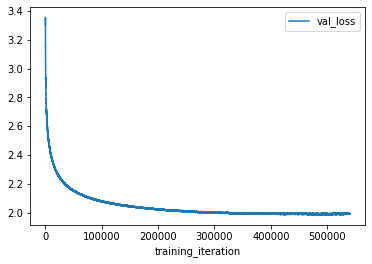

In [ ]:
best_result.metrics_dataframe.plot("training_iteration", "val_loss")

Text(0, 0.5, 'Mean Test Accuracy')

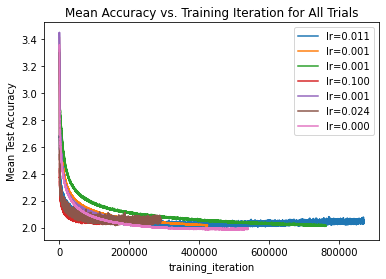

In [ ]:
ax = None
for result in result_grid:
    label = f"lr={result.config['lr']:.3f}"
    if ax is None:
        ax = result.metrics_dataframe.plot("training_iteration", "val_loss", label=label)
    else:
        result.metrics_dataframe.plot("training_iteration", "val_loss", ax=ax, label=label)
ax.set_title("Mean Accuracy vs. Training Iteration for All Trials")
ax.set_ylabel("Mean Test Accuracy")

### Train and Test with Best Config

In [ ]:
best_result.metrics

{'training_iteration': 540059,
 'train_loss': 1.7585725784301758,
 'val_loss': 1.9896790981292725,
 'time_this_iter_s': 0.06922125816345215,
 'done': True,
 'timesteps_total': None,
 'episodes_total': None,
 'trial_id': 'f6250653',
 'experiment_id': '352e72ef24b0485790725bb268154829',
 'date': '2023-03-20_03-45-17',
 'timestamp': 1679283917,
 'time_total_s': 35661.531294584274,
 'pid': 88428,
 'hostname': '129-146-49-170',
 'node_ip': '10.19.31.32',
 'config': {'n_embd': 24,
  'n_hidden': 456,
  'lr': 0.0004390312584437158,
  'last_layer_factor': 0.9956496873025195,
  'batch_size': 64,
  'max_steps': 540060},
 'time_since_restore': 35661.531294584274,
 'timesteps_since_restore': 0,
 'iterations_since_restore': 540060,
 'warmup_time': 0.003042936325073242,
 'experiment_tag': '2_batch_size=64,last_layer_factor=0.9956,lr=0.0004,max_steps=540060,n_embd=24,n_hidden=456'}

In [ ]:
config = {'n_embd': 24,
  'n_hidden': 456,
  'lr': 0.0004390312584437158,
  'last_layer_factor': 0.9956496873025195,
  'batch_size': 64,
  'max_steps': 540060}

In [ ]:
model = train_no_tune(config)

No of parameters  869355
Initial loss  tensor(3.4630, device='cuda:0', grad_fn=<NllLossBackward>)
      0/ 540060: 3.4067
  10000/ 540060: 2.4061
  20000/ 540060: 2.1215
  30000/ 540060: 2.2546
  40000/ 540060: 2.2071
  50000/ 540060: 2.1789
  60000/ 540060: 2.5076
  70000/ 540060: 2.0653
  80000/ 540060: 1.9867
  90000/ 540060: 1.9995
 100000/ 540060: 2.2169
 110000/ 540060: 2.2312
 120000/ 540060: 2.0663
 130000/ 540060: 1.8910
 140000/ 540060: 1.9463
 150000/ 540060: 2.0409
 160000/ 540060: 1.8872
 170000/ 540060: 2.1610
 180000/ 540060: 1.8664
 190000/ 540060: 2.0235
 200000/ 540060: 1.8428
 210000/ 540060: 1.8524
 220000/ 540060: 1.9312
 230000/ 540060: 1.8659
 240000/ 540060: 1.7783
 250000/ 540060: 1.8855
 260000/ 540060: 2.0965
 270000/ 540060: 1.8449
 280000/ 540060: 2.2505
 290000/ 540060: 2.0819
 300000/ 540060: 1.9650
 310000/ 540060: 1.8367
 320000/ 540060: 1.9641
 330000/ 540060: 2.1167
 340000/ 540060: 1.8066
 350000/ 540060: 1.8251
 360000/ 540060: 1.5952
 370000/ 54006

In [ ]:
for layer in model.layers: layer.training = False

with torch.no_grad():
    train_loss = F.cross_entropy(model(Xtr), Ytr)
    val_loss = F.cross_entropy(model(Xdev), Ydev)
    test_loss = F.cross_entropy(model(Xte), Yte)
    print('Train loss ', train_loss)
    print('Val loss ', val_loss)
    print('Test loss ', test_loss)

Train loss  tensor(1.7622, device='cuda:0')
Val loss  tensor(1.9855, device='cuda:0')
Test loss  tensor(1.9815, device='cuda:0')
